In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
line_type = {'solid line' : 'solid', ## 라인 유형
             'dashed line' : 'dashed',
             'dash-dotted line' : 'dashdot',
             'dotted line' : 'dotted'}

In [3]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [4]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [6]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [7]:
train_data.shape,test_data.shape

((210,), (60,))

In [8]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


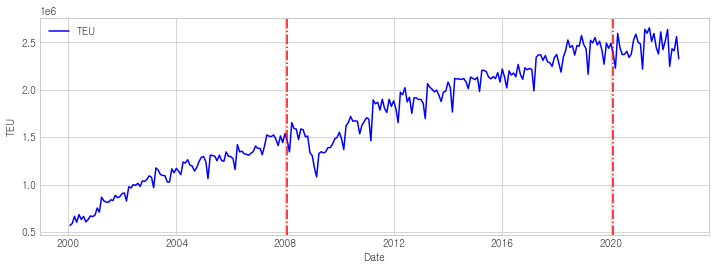

In [9]:
plt.figure(figsize=(12,4))
plt.plot(data['TEU'], 'blue', label='TEU')
plt.xlabel('Date')
plt.ylabel('TEU')
plt.axvline(x='2008-01-31',color='red',linestyle='dashdot')
plt.axvline(x='2020-01-31',color='red',linestyle='dashdot')
plt.legend()

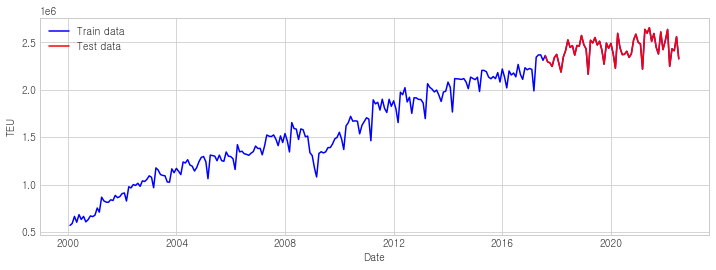

In [10]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

### 2. 다변량 LSTM

In [11]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [12]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [13]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [14]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [15]:
raw_df = data

In [16]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

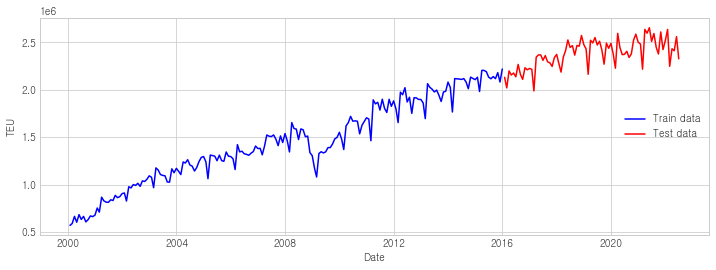

In [17]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend(loc=5)

In [18]:
len(train),len(test)

(192, 78)

In [19]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [21]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [22]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [23]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [24]:
X_train.shape,Y_train.shape

((163, 18, 10), (163, 12, 1))

### 2. X_test,Y_test 배열

In [25]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_test= X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_test= Y 종속변수 예측값 

In [26]:
X_test.shape,Y_test.shape

((49, 18, 10), (49, 12, 1))

In [27]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [28]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(LSTM(64,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(RepeatVector(12)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(64, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
16/16 [==============================] - 9s 346ms/step - loss: 0.3216 - mae: 0.5177 - val_loss: 0.2635 - val_mae: 0.4515
Epoch 2/200
16/16 [==============================] - 0s 21ms/step - loss: 0.1399 - mae: 0.3016 - val_loss: 0.2713 - val_mae: 0.4704
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0882 - mae: 0.2365 - val_loss: 0.1866 - val_mae: 0.3712
Epoch 4/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0757 - mae: 0.2164 - val_loss: 0.1171 - val_mae: 0.2813
Epoch 5/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0543 - mae: 0.1824 - val_loss: 0.1365 - val_mae: 0.3159
Epoch 6/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0487 - mae: 0.1698 - val_loss: 0.1289 - val_mae: 0.3183
Epoch 7/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0378 - mae: 0.1515 - val_loss: 0.0876 - val_mae: 0.2429
Epoch 8/200
16/16 [==============================] - 0s 18ms/step - loss: 0

In [29]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

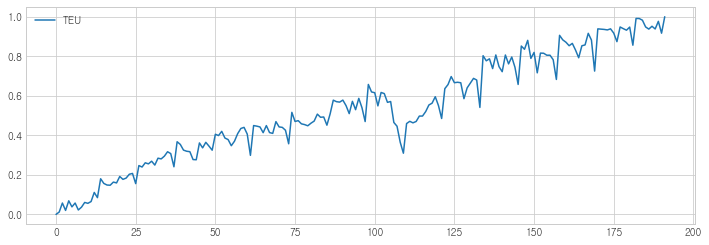

In [30]:
label_train.plot()

<AxesSubplot:>

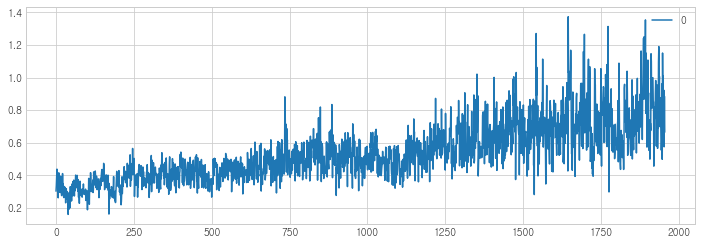

In [31]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

#### Most Probable Explanation

### 1. 2017.07 ~ 2018.06

In [32]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [33]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [34]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

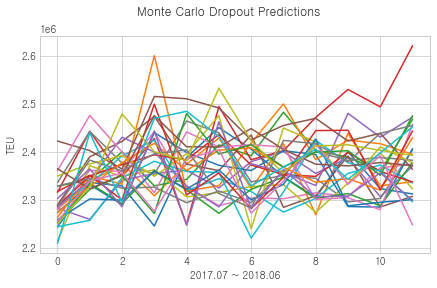

In [35]:
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2018.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [36]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [37]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [38]:
np.mean(df.std()/df.mean())

0.02447410114109516

In [39]:
df.to_csv('LSTM1.csv')

In [40]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 40778.06854994849
MAPE: 1.4030506860713867


In [41]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[:12]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2244370.75,2281273.0,2328777.75,2315856.5,2283098.75,2289950.25,2279667.75,2336052.75,2214662.75,2288736.5,2274132.25,2264409.25,2251454.5,2288214.5,2285716.5,2422496.0,2361008.75,2329211.5,2349758.25,2244408.0,2259074.75,2273405.25,2254311.5,2317962.25,2303277.25,2365035.75,2255463.75,2286107.25,2250499.5,2209955.75


In [42]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:222]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2018-06-30,2443990,1385,2.926085,2.901474,4.385095,110.3,7980.1,1092.8,137274768,103.55


In [43]:
df.to_csv('LSTM.csv')

Mean RMSE: 96164.74937125047
Mean MAPE: 3.42546406750805


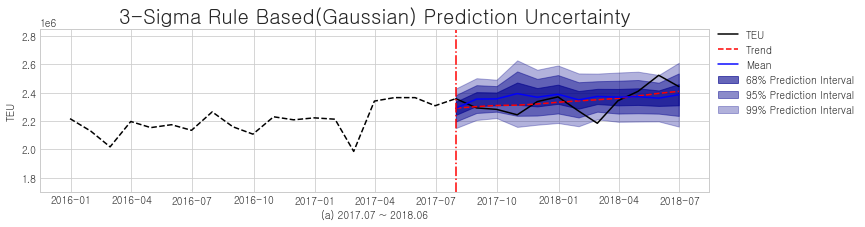

In [44]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().mean())/ test_data.head(12).reset_index()['TEU'])*100) )

In [45]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.75


Median RMSE: 94849.85637789629
Median MAPE: 3.433152385225458


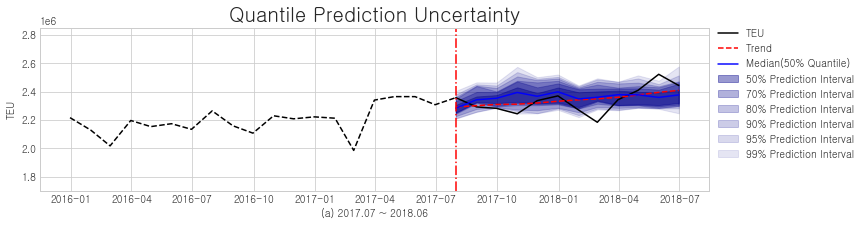

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.head(12).reset_index()['TEU'])*100) )

In [47]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.8333333333333334


In [48]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 118815.96
Quantile 70% Interval Sharpness 115581.86770833326


RMSE: 98398.69786456887
MAPE: 3.29303698487956


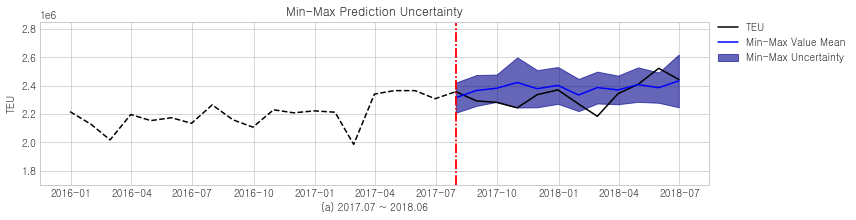

In [49]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(12).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [50]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666


In [51]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 237631.88
Quantile 95% Interval Sharpness 205555.39062499997
Min Max Interval Sharpness 248575.23


In [52]:
import CRPS.CRPS as pscore

In [53]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(12).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

48011.5375
41209.16194444445
49162.657777777764
106340.39861111109
19789.110833333332
19941.31083333333
49370.72055555556
159985.0577777778
21089.225555555553
24054.319166666664
130915.36916666667
37077.36944444444


In [54]:
a = np.array([48011.5375,
41209.16194444445,
49162.657777777764,
106340.39861111109,
19789.110833333332,
19941.31083333333,
49370.72055555556,
159985.0577777778,
21089.225555555553,
24054.319166666664,
130915.36916666667,
37077.36944444444])

In [55]:
np.mean(a)

58912.18659722222

In [56]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2363642.0

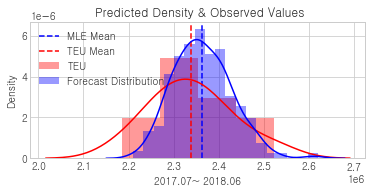

In [57]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(12).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017.07~ 2018.06')
plt.legend(loc=2)

In [58]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(12).reset_index()['TEU'].mean(), scale=test_data.head(12).reset_index()['TEU'].std() ) )
LL

4548.6647515660925

In [59]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5035.778939417686

In [60]:
LL = -np.sum( stats.norm.logpdf(test_data.head(12).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

203.1479420955718

In [61]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [62]:
for i in range(0,30):
    print(KL(df[i],test_data.head(12).reset_index()['TEU']))

54633.221856970675
189428.57028603635
621558.4395983277
1160193.1298379481
92101.02381572394
303131.35260578664
10126.044993247502
420587.6835141438
128271.09719372638
19585.749696109735
219055.47139706122
729907.4735342123
248499.41011171168
357558.96442791104
478681.9767657785
1273474.4015995215
551796.1781129958
98174.70443407036
536415.1107682885
98024.97739222433
183621.88475112244
336923.09124566196
448783.90708704747
386594.2804504762
6064.3275374122895
658224.6241387837
20338.422205753508
502336.25485656667
746744.0166397217
602387.7659473289


In [63]:
a = np.array([54633.221856970675,
189428.57028603635,
621558.4395983277,
1160193.1298379481,
92101.02381572394,
303131.35260578664,
10126.044993247502,
420587.6835141438,
128271.09719372638,
19585.749696109735,
219055.47139706122,
729907.4735342123,
248499.41011171168,
357558.96442791104,
478681.9767657785,
1273474.4015995215,
551796.1781129958,
98174.70443407036,
536415.1107682885,
98024.97739222433,
183621.88475112244,
336923.09124566196,
448783.90708704747,
386594.2804504762,
6064.3275374122895,
658224.6241387837,
20338.422205753508,
502336.25485656667,
746744.0166397217,
602387.7659473289])

In [64]:
np.mean(a)

382774.1185600557

### 2. 2018.07 ~ 2019.06

In [65]:
X_test_2 = np.array(feature_test[12:30]).reshape((1, 18, 10)) 

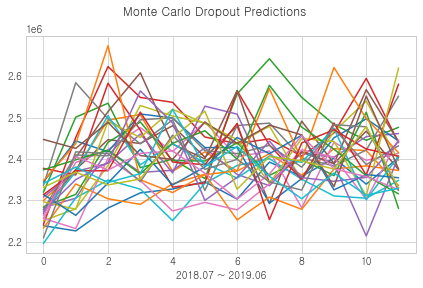

In [66]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2018.07 ~ 2019.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [67]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [68]:
np.mean(df.std()/df.mean())

0.030771100893616676

In [69]:
df.to_csv('LSTM2.csv')

In [70]:
rmse = math.sqrt(mean_squared_error(trend[12:24].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[12:24].reset_index()['TEU_Trend']- df.transpose().median())/ trend[12:24].reset_index()['TEU_Trend'])*100) )

RMSE: 55220.53797478724
MAPE: 1.8656641480574159


In [71]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[12:24]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-31,2238699.25,2299389.0,2319575.25,2241736.0,2282410.25,2277549.5,2256455.5,2336100.25,2250903.0,2195915.25,2344454.0,2232887.75,2284420.75,2377210.25,2307784.25,2267844.5,2256234.25,2277292.25,2296315.5,2272300.0,2314254.25,2347444.75,2373720.75,2313559.0,2273489.5,2447036.75,2263731.5,2209496.5,2331217.25,2340481.5


In [72]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:234]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2019-06-30,2469920,1354,2.840263,2.897122,4.424881,109.8,6166.1,1175.62,140568904,100.79


Mean RMSE: 115806.65693235843
Mean MAPE: 3.8180629906080856


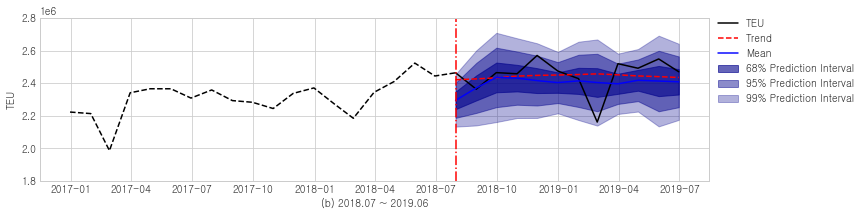

In [73]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [74]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.9166666666666666


Median RMSE: 118869.64291620482
Median MAPE: 3.983505083472378


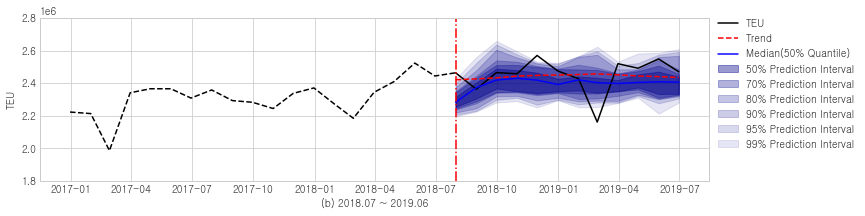

In [75]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [76]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.9166666666666666


In [77]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 151028.95
Quantile 70% Interval Sharpness 142782.62187499995


RMSE: 119921.26506633165
MAPE: 3.62997580276635


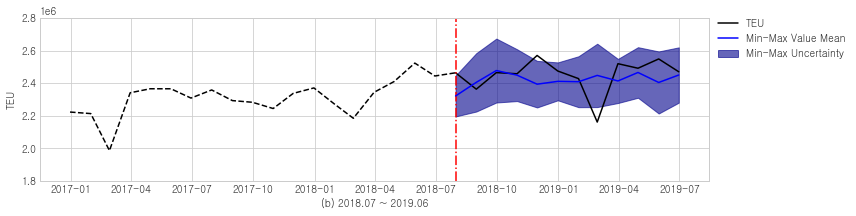

In [78]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [79]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75


In [80]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 302057.84
Quantile 95% Interval Sharpness 265532.45260416664
Min Max Interval Sharpness 319894.16


In [81]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[12:24].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

140246.33166666667
15896.079166666665
30448.6775
26040.946388888897
111460.29694444445
45724.99194444443
18116.480555555554
195238.81555555557
91434.62138888889
48603.11583333334
88144.47694444444
43630.9138888889


In [82]:
a = np.array([140246.33166666667,
15896.079166666665,
30448.6775,
26040.946388888897,
111460.29694444445,
45724.99194444443,
18116.480555555554,
195238.81555555557,
91434.62138888889,
48603.11583333334,
88144.47694444444,
43630.9138888889])

In [83]:
np.mean(a)

71248.81231481482

In [84]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2400373.2

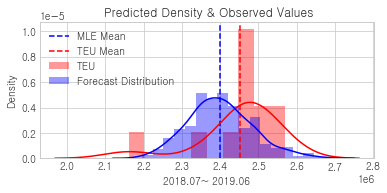

In [85]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[12:24].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[12:24].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2018.07~ 2019.06')
plt.legend(loc=2)

In [86]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[12:24].reset_index()['TEU'].mean(), scale=test_data.iloc[12:24].reset_index()['TEU'].std() ) )
LL

4648.532456520865

In [87]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5018.947954884039

In [88]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[12:24].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

192.98107438012744

In [89]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[12:24].reset_index()['TEU']))

1406456.3725188184
584865.7596953718
300086.86269906943
271738.6836369038
773941.7779637177
479190.1037430168
557555.069197745
37884.737560422334
268541.99213445577
1456784.8751601772
290961.8522094615
1504508.5746246255
704863.031388781
116250.19298023196
665834.945950806
27455.24502015167
1346331.9059772654
351404.6311723001
247994.05717048372
675252.5266367296
935411.3335023711
21755.454529096467
339490.4093718596
563333.9350777252
695021.4753878709
80013.68620685252
944819.1108165508
801564.062637412
708745.3108931957
936805.1576433645


In [90]:
a = np.array([1406456.3725188184,
584865.7596953718,
300086.86269906943,
271738.6836369038,
773941.7779637177,
479190.1037430168,
557555.069197745,
37884.737560422334,
268541.99213445577,
1456784.8751601772,
290961.8522094615,
1504508.5746246255,
704863.031388781,
116250.19298023196,
665834.945950806,
27455.24502015167,
1346331.9059772654,
351404.6311723001,
247994.05717048372,
675252.5266367296,
935411.3335023711,
21755.454529096467,
339490.4093718596,
563333.9350777252,
695021.4753878709,
80013.68620685252,
944819.1108165508,
801564.062637412,
708745.3108931957,
936805.1576433645])

In [91]:
np.mean(a)

603162.1044502278

### 3. 2019.07 ~ 2020.06

In [92]:
X_test_3 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

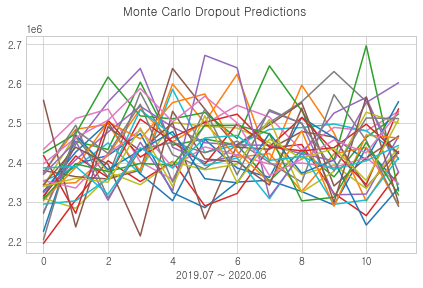

In [93]:
model_MC=  model
prediction = [model_MC.predict(X_test_3) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2020.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [94]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [95]:
np.mean(df.std()/df.mean())

0.033062923699617386

In [96]:
df.to_csv('LSTM3.csv')

In [97]:
rmse = math.sqrt(mean_squared_error(trend[24:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[24:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[24:36].reset_index()['TEU_Trend'])*100) )

RMSE: 35465.986395411775
MAPE: 1.1206767548355836


In [98]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[24:36]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2327073.25,2344714.25,2311160.5,2196099.75,2275357.0,2380553.0,2433981.5,2272251.5,2310358.75,2353886.75,2327212.25,2375109.75,2424503.0,2315872.25,2324697.25,2558295.75,2354930.5,2373986.5,2342152.5,2295452.25,2226451.5,2304363.25,2308588.25,2418617.5,2370230.25,2344363.0,2397293.25,2205231.75,2340061.25,2387077.75


In [99]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2020-06-30,2371415,1799,2.70092,2.992441,4.411836,110.4,7039.3,1210.01,116998896,95.01


Mean RMSE: 106858.22924842699
Mean MAPE: 3.529269608411056


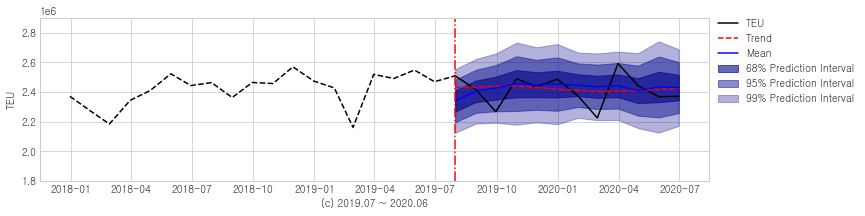

In [100]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.9e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [101]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 0.9166666666666666


Median RMSE: 108143.1026482893
Median MAPE: 3.566693275569497


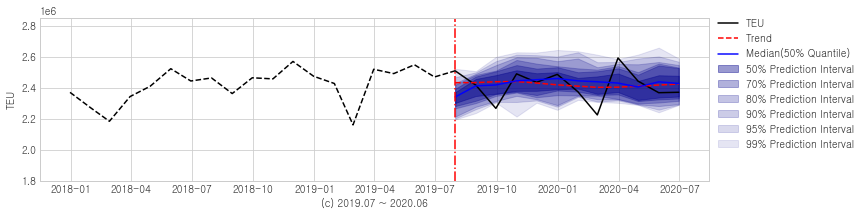

In [102]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [103]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.9166666666666666


In [104]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 164579.38
Quantile 70% Interval Sharpness 161155.85104166667


RMSE: 120214.07298592202
MAPE: 4.1523803107835535


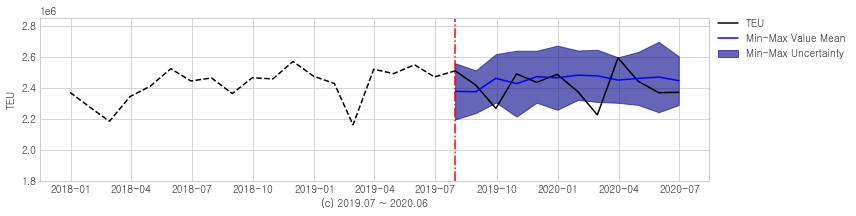

In [105]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [106]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334


In [107]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 329158.72
Quantile 95% Interval Sharpness 282021.8828124999
Min Max Interval Sharpness 347903.9


In [108]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[24:36].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

135241.5677777778
18957.773333333334
115698.07138888889
28989.975
21429.09833333334
23655.15416666667
41299.74722222223
168737.53027777773
107072.34305555555
26717.971388888887
42728.939999999995
38138.0938888889


In [109]:
a = np.array([135241.5677777778,
18957.773333333334,
115698.07138888889,
28989.975,
21429.09833333334,
23655.15416666667,
41299.74722222223,
168737.53027777773,
107072.34305555555,
26717.971388888887,
42728.939999999995,
38138.0938888889])

In [110]:
np.mean(a)

64055.52215277778

In [111]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2427210.0

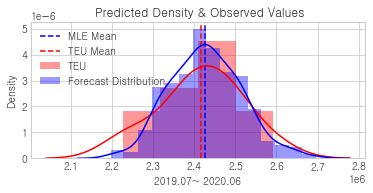

In [112]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[24:36].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[24:36].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2020.06')
plt.legend(loc=2)

In [113]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[24:36].reset_index()['TEU'].mean(), scale=test_data.iloc[24:36].reset_index()['TEU'].std() ) )
LL

4616.474899113573

In [114]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5400.140557899631

In [115]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[24:36].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

193.1163413284189

In [116]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[24:36].reset_index()['TEU']))

596839.0062127723
485694.87946562795
343903.1863819065
796772.4355209788
392322.5132045751
293991.09181968373
808810.937667918
648515.1694697002
123653.85587119774
457419.30158030486
138351.35006475865
220530.80732191936
1251269.2128661145
269833.78447997593
536172.2609193824
260949.84932903893
163886.39991469224
66786.85470280598
32235.697599262116
436131.0719003214
397734.5701892754
323292.7364741017
204976.6261679722
394688.28305478406
591214.6958395652
152047.44226903853
774899.5421649707
432674.3337590967
29650.401016913733
50634.21045519787


In [117]:
a = np.array([596839.0062127723,
485694.87946562795,
343903.1863819065,
796772.4355209788,
392322.5132045751,
293991.09181968373,
808810.937667918,
648515.1694697002,
123653.85587119774,
457419.30158030486,
138351.35006475865,
220530.80732191936,
1251269.2128661145,
269833.78447997593,
536172.2609193824,
260949.84932903893,
163886.39991469224,
66786.85470280598,
32235.697599262116,
436131.0719003214,
397734.5701892754,
323292.7364741017,
204976.6261679722,
394688.28305478406,
591214.6958395652,
152047.44226903853,
774899.5421649707,
432674.3337590967,
29650.401016913733,
50634.21045519787])

In [118]:
np.mean(a)

389196.08358946175

### 4. 2020.07 ~ 2021.06

In [119]:
X_test_4 = np.array(feature_test[36:54]).reshape((1, 18, 10)) 

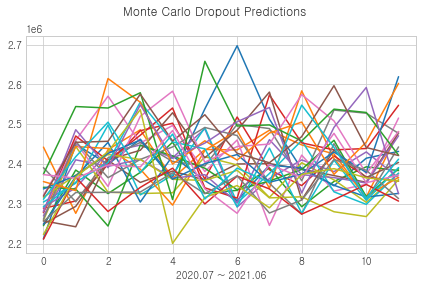

In [120]:
model_MC=  model
prediction = [model_MC.predict(X_test_4) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2020.07 ~ 2021.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [121]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [122]:
np.mean(df.std()/df.mean())

0.03095598891377449

In [123]:
df.to_csv('LSTM4.csv')

In [124]:
rmse = math.sqrt(mean_squared_error(trend[36:48].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[36:48].reset_index()['TEU_Trend']- df.transpose().median())/ trend[36:48].reset_index()['TEU_Trend'])*100) )

RMSE: 97157.89242961603
MAPE: 3.5128993116508145


In [125]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[36:48]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-31,2212165.0,2442270.0,2245033.75,2288572.25,2291493.25,2249350.25,2321542.25,2390650.25,2258690.0,2304460.25,2248269.75,2279204.75,2341445.5,2277810.5,2269517.0,2257247.5,2282612.25,2261398.5,2316106.25,2292662.0,2337336.5,2355688.0,2374511.0,2211103.25,2280026.0,2319041.0,2373237.0,2255407.5,2222999.0,2311482.0


In [126]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:258]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2021-06-30,2507761,3383,3.40973,3.569689,4.537851,117.6,8830.5,1121.3,130920264,107.4


Mean RMSE: 151378.9761361056
Mean MAPE: 5.2691741993953745


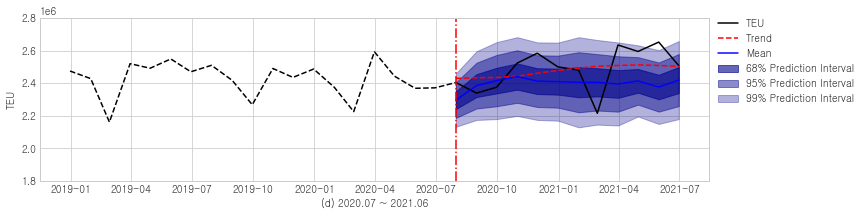

In [127]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [128]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334
추세 변동에 대한 포함확률: 0.5


Median RMSE: 156227.27457655143
Median MAPE: 5.387643528496876


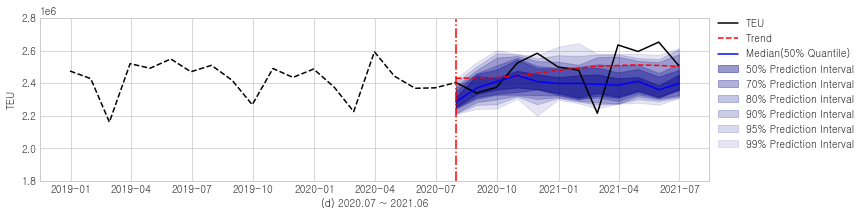

In [129]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [130]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334
추세 변동에 대한 포함확률: 0.4166666666666667


In [131]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 155729.83
Quantile 70% Interval Sharpness 149253.99791666653


RMSE: 133177.02752228657
MAPE: 4.373710625233104


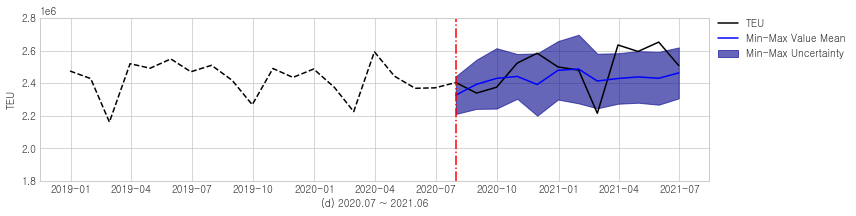

In [132]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [133]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666


In [134]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 311459.66
Quantile 95% Interval Sharpness 269834.7640625
Min Max Interval Sharpness 328172.16


In [135]:
test_data.iloc[36:48].reset_index()['TEU'][0]

2404026

In [136]:
test_data.iloc[36:48].reset_index()['TEU'][0]

2404026

In [137]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[36:48].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

81219.57333333333
26375.606666666667
26204.317500000005
51404.444166666675
128183.55055555556
62433.56083333334
46569.92138888889
141967.36083333337
192424.9922222222
140579.6497222222
236313.24222222224
62696.52638888889


In [138]:
a = np.array([81219.57333333333,
26375.606666666667,
26204.317500000005,
51404.444166666675,
128183.55055555556,
62433.56083333334,
46569.92138888889,
141967.36083333337,
192424.9922222222,
140579.6497222222,
236313.24222222224,
62696.526388888891])

In [139]:
np.mean(a)

99697.72881944447

In [140]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2397439.8

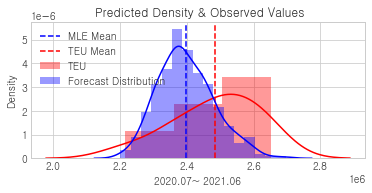

In [141]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[36:48].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2020.07~ 2021.06')
plt.legend(loc=2)

In [142]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[36:48].reset_index()['TEU'].mean(), scale=test_data.iloc[36:48].reset_index()['TEU'].std() ) )
LL

4725.162606826233

In [143]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5092.3390306553365

In [144]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[36:48].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

242.49533850417475

In [145]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[36:48].reset_index()['TEU']))

505901.1935253842
713794.5304693572
1462309.8191990561
1013055.8621731029
1100034.2053988003
1298729.2624781907
744723.4304306257
510681.44780940213
1466735.3725429208
1243023.4634160807
1478269.5936652236
959128.7942378132
1322857.4396590393
469906.8530180789
1177927.934190242
857069.8163310309
349803.22229750984
1007557.1935283736
1543569.7597760067
1107758.9654292045
816293.786122209
210814.27770707442
201875.17581252955
1867053.0021310195
386547.6565565805
230342.94684041673
1151568.797374689
1718241.2301551173
1522294.9129518757
892548.7508699043


In [146]:
a = np.array([505901.1935253842,
713794.5304693572,
1462309.8191990561,
1013055.8621731029,
1100034.2053988003,
1298729.2624781907,
744723.4304306257,
510681.44780940213,
1466735.3725429208,
1243023.4634160807,
1478269.5936652236,
959128.7942378132,
1322857.4396590393,
469906.8530180789,
1177927.934190242,
857069.8163310309,
349803.22229750984,
1007557.1935283736,
1543569.7597760067,
1107758.9654292045,
816293.786122209,
210814.27770707442,
201875.17581252955,
1867053.0021310195,
386547.6565565805,
230342.94684041673,
1151568.797374689,
1718241.2301551173,
1522294.9129518757,
892548.7508699043])

In [147]:
np.mean(a)

977680.6232032287

### 5. 2021.07 ~ 2022.06

In [148]:
X_test_5 = np.array(feature_test[48:66]).reshape((1, 18, 10)) 

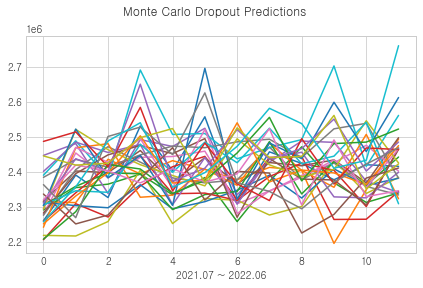

In [149]:
model_MC=  model
prediction = [model_MC.predict(X_test_5) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2021.07 ~ 2022.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [150]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [151]:
df.to_csv('LSTM5.csv')

In [152]:
np.mean(df.std()/df.mean())

0.03153139352798462

In [153]:
rmse = math.sqrt(mean_squared_error(trend[48:60].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[48:60].reset_index()['TEU_Trend']- df.transpose().median())/ trend[48:60].reset_index()['TEU_Trend'])*100) )

RMSE: 111615.27832361012
MAPE: 4.1502390255406345


In [154]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[48:60]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-31,2261280.75,2315605.0,2292023.5,2207258.0,2447443.25,2317260.0,2279431.0,2276832.75,2219529.75,2390907.0,2313503.75,2242716.5,2305407.75,2260205.0,2401728.0,2283318.0,2295650.5,2384824.25,2295048.75,2306070.0,2304176.25,2252388.0,2208709.25,2487214.75,2311166.25,2337258.25,2321146.0,2364021.75,2445902.0,2258221.0


In [155]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2022-06-30,2324505,2240,3.749211,3.625297,4.488265,120.1,5609.8,1277.35,118631016,132.61


Mean RMSE: 143655.48661995344
Mean MAPE: 4.563458806259657


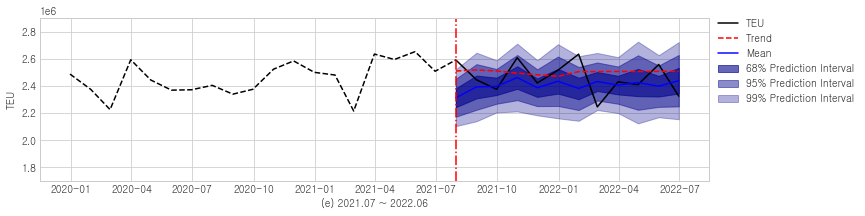

In [156]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='darkblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='darkblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(12).reset_index()['TEU'])*100) )

In [157]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.3333333333333333


Median RMSE: 151718.0790539876
Median MAPE: 4.795364151905867


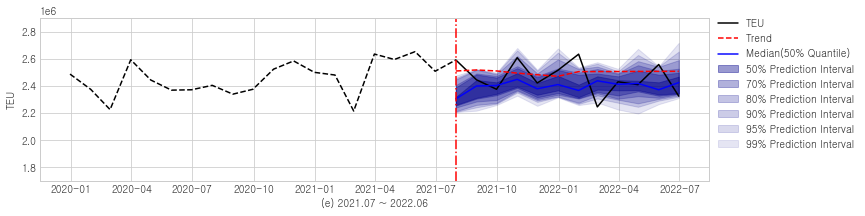

In [158]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='darkblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='darkblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='darkblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='darkblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='darkblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='darkblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.tail(12).reset_index()['TEU'])*100) )

In [159]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.25


In [160]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 158081.12
Quantile 70% Interval Sharpness 150923.72604166679


RMSE: 140081.22805073892
MAPE: 4.490371600746659


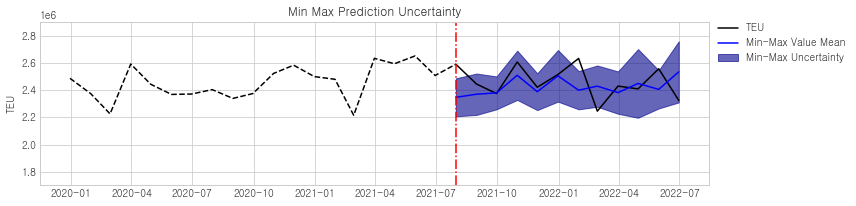

In [161]:
plt.figure(figsize=(12,3))
plt.grid(True)
#plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='blue',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='darkblue',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.tail(12).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [162]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666


In [163]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 316162.25
Quantile 95% Interval Sharpness 277620.25885416666
Min Max Interval Sharpness 331102.1


In [164]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[48:60].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

240605.37111111113
32260.422777777778
21175.029722222225
109928.16916666669
25777.72861111111
55505.84916666667
208816.8011111111
148124.54750000004
16700.77388888889
17475.00972222222
117645.74638888889
66064.17611111111


In [165]:
a = np.array([240605.37111111113,
32260.422777777778,
21175.029722222225,
109928.16916666669,
25777.72861111111,
55505.84916666667,
208816.8011111111,
148124.54750000004,
16700.77388888889,
17475.00972222222,
117645.74638888889,
66064.17611111111])

In [166]:
np.mean(a)

88339.96877314815

In [167]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2405626.2

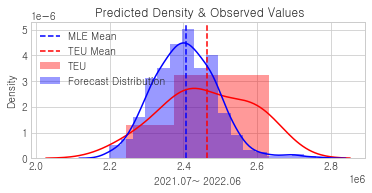

In [168]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[48:60].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[48:60].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2021.07~ 2022.06')
plt.legend(loc=2)

In [169]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[48:60].reset_index()['TEU'].mean(), scale=test_data.iloc[48:60].reset_index()['TEU'].std() ) )
LL

4676.194428343702

In [170]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

5056.864006709309

In [171]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[48:60].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

205.78337260403825

In [172]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[48:60].reset_index()['TEU']))

615705.7684659634
944483.7035086046
1223183.9086760336
1365832.8297860376
304207.5846256735
594048.7090179339
689522.3049453173
806071.0450463269
1721832.7465942698
559511.7697980164
1370925.6303594115
780320.874859749
986233.3527983793
1028485.7872188112
667208.464734134
689578.5498540568
659589.2169878375
26577.032329659167
376294.59285068436
477522.3669358147
105749.14851445096
718240.7498298542
553878.3858629314
219996.9341761115
61557.365399652976
1341745.1907662633
793577.9616413777
491853.86291958415
84758.58034871724
145720.31399628456


In [173]:
a = np.array([615705.7684659634,
944483.7035086046,
1223183.9086760336,
1365832.8297860376,
304207.5846256735,
594048.7090179339,
689522.3049453173,
806071.0450463269,
1721832.7465942698,
559511.7697980164,
1370925.6303594115,
780320.874859749,
986233.3527983793,
1028485.7872188112,
667208.464734134,
689578.5498540568,
659589.2169878375,
26577.032329659167,
376294.59285068436,
477522.3669358147,
105749.14851445096,
718240.7498298542,
553878.3858629314,
219996.9341761115,
61557.365399652976,
1341745.1907662633,
793577.9616413777,
491853.86291958415,
84758.58034871724,
145720.31399628456])

In [174]:
np.mean(a)

680140.4910949315

In [175]:
KL(df.transpose(),test_data.reset_index()['TEU'])

1770